# Machine Learning Demonstrations

In this notebook, we showcase how to use kdb+/q paired with embedPy to carry out machine learning tasks.

Below we will examine the impact of applying scaling algorithms on a k-nearest neighbours classification model, applied to the Wisconsin Breast Cancer dataset. We will then investigate the impact of using one-hot encoding vs. basic enumeration using a neural network applied to the MNIST dataset.

<div class="alert alert-danger">
To run the below notebook, ensure that dependencies specified in <b>requirements.txt</b> have been correctly installed.
</div>

## EmbedPy

EmbedPy allows the kdb+/q interpreter to manipulate Python objects, call Python functions and load Python libraries. Python and kdb+/q developers can fuse both technologies together, allowing for a seamless application of kdb+/q’s high-speed analytics and Python’s rich ecosystem of libraries such as scikit-learn, Tensorflow, PyTorch and Theano.

## Feature Engineering

Feature engineering is the process of modifying input features to make machine learning algorithms work more effectively. Manual feature engineering requires both:
- Knowledge of the chosen algorithm.
- Domain knowledge of the dataset.

## Normalization

Certain machine learning algorithms (e.g. k-nearest neighbours) require the calculation of a distance between points in the feature space. The features must, therefore, all be on the same scale otherwise the feature with the most magnified scale will get the highest weighting.

The process of scaling features is called **normalization**. A number of algorithms are available within scikit-learn to carry out the process of feature scaling:

[Standard Scaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler):
- Scales data via a linear transformation that transforms the mean value of each feature to 0 and the standard deviation of each feature to 1.
- This has the advantage of being simple, fast and easily explainable.
- However, standard scalar is not robust to outliers.

[MinMax Scaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler):
- Scales data via a linear transformation that transforms the minimum and maximum values of each feature to [0,1]. - This again has the advantage of being simple, fast and easily explainable.
- However, standard scalar is not robust to outliers.

[Robust Scaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html#sklearn.preprocessing.RobustScaler):
- Scales data via a linear transformation that transforms the interquartile range of each feature to [-1,1].
- This scaler is robust to the presence of outliers, as they will lie outside the interquartile range.
- However, outliers will continue to lie away from the majority of points and can therefore have an outsize impact on predictions.

[Quantiles Transformer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html#sklearn.preprocessing.QuantileTransformer):
- Converts the distribution of each feature to a standard normal distribution. This is not a linear transformation, but a transformation based on the distribution of the inputs.
- This transformation is very sensitive to outliers, but the distribution of the scalar's output is always the same.
- This method would be most relevant where the levels of a feature were basically meaningless, but the rank ordering of the feature was important.

We can look at the effect of the four different normalizers on random data generated from four different distributions:
- Normal
- Uniform
- Gamma
- Student-T
- Mixture of gaussians

Looking at the normalized distributions, we see that the effect of normalization can be quite different, depending on the distribution of the unscaled data, e.g. even after applying the Standard Scaler, data drawn from fat-tailed distributions still have values that are an order-of-magnitude larger than others. 

<img src="../images/scalers.png" />

### Sections

This notebook is split into two sections:

1. [Breast Cancer Data](#Breast-Cancer)
2. [MNIST Dataset](#MNIST)

In [1]:
/ load toolkit and graphics functions
\l ml/ml.q
.ml.loadfile`:util/init.q
\l ../utils/graphics.q
\l ../utils/util.q

---

<a id='Breast-Cancer'></a>
# Breast Cancer Data

The [Wisconsin Breast Cancer Dataset](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29) is a set of 569 samples of fine needle aspirate (FNA) of breast mass. Each sample contains features describing characteristics of the cell nuclei, along with a classification of the sample as either benign or malignant.

### Load data

In the cell below, we load in the utilities library from the kdb+/q [ML-Toolkit](https://github.com/KxSystems/ml), along with graphics functions required for this notebook. We then use embedPy to import relevant python modules and load data from the Wisconsin Breast Cancer dataset.

Data is split into training and testing sets where we chosen to select 50% of the data for the testing set.

In [2]:
/ load data and split into train/test sets
data:.p.import[`sklearn.datasets;`:load_breast_cancer][]
feat:data[`:data]`
targ:data[`:target]`
datadict:.ml.traintestsplit[feat;targ;.5]

/ inspect data
-1"Shape of features is ",sv[" x "]string .ml.shape feat;
-1"";show 5#feat;-1"";
-1"Distribution of target values is:\n";
show update pcnt:round[;.01]100*num%sum num from select num:count i by target from([]target:targ);
-1"\nTraining/test split is:\n";
show count each datadict

Shape of features is 569 x 30

17.99 10.38 122.8 1001  0.1184  0.2776  0.3001 0.1471  0.2419 0.07871 1.095  ..
20.57 17.77 132.9 1326  0.08474 0.07864 0.0869 0.07017 0.1812 0.05667 0.5435 ..
19.69 21.25 130   1203  0.1096  0.1599  0.1974 0.1279  0.2069 0.05999 0.7456 ..
11.42 20.38 77.58 386.1 0.1425  0.2839  0.2414 0.1052  0.2597 0.09744 0.4956 ..
20.29 14.34 135.1 1297  0.1003  0.1328  0.198  0.1043  0.1809 0.05883 0.7572 ..

Distribution of target values is:

target| num pcnt 
------| ---------
0     | 212 37.26
1     | 357 62.74

Training/test split is:

xtrain| 284
ytrain| 284
xtest | 285
ytest | 285


We have deliberately retained a large proportion (50%) of our data for final testing so that the accuracy rates reflect performance on a significant amount of 'previously unseen' data.

### Preprocess data and test models

Below we compare four methods of normalization by applying each to the dataset and training/testing a k-nearest neighbours classifier.

A maximum value of k equal to 200 is used throughout.

In [3]:
/ import normalization methods
preproc:.p.import[`sklearn.preprocessing]
standard:preproc`:StandardScaler
minmax:  preproc`:MinMaxScaler
robust:  preproc`:RobustScaler
quantile:preproc`:QuantileTransformer

/ import classifier
knclassifier:.p.import[`sklearn.neighbors]`:KNeighborsClassifier

/ inputs
maxk:200
colors:`r`g`b`y`k
normalizers:standard[],minmax[],robust[],quantile[]
name:`Standard`MinMax`Robust`Quantiles;
accs:(count[normalizers],maxk)#`float$0

In [4]:
/ cross validation function
xval:{[i;norm;k]
 clf:knclassifier k;
 clf[`:fit][norm[`:transform]datadict`xtest;datadict`ytest];
 pred:clf[`:predict][norm[`:transform]datadict`xtest]`;
 accs[i;k-1]::.ml.accuracy[pred;datadict`ytest];}

/ function to perform cross validation, plot accuracy results
results:{[i;norm;name;k]
 normalizer:norm[i][`:fit]datadict`xtrain;
 xval[i;normalizer]each 1+til k;
 ax[`:plot][til k;accs i;colors i;`label pykw name i];}

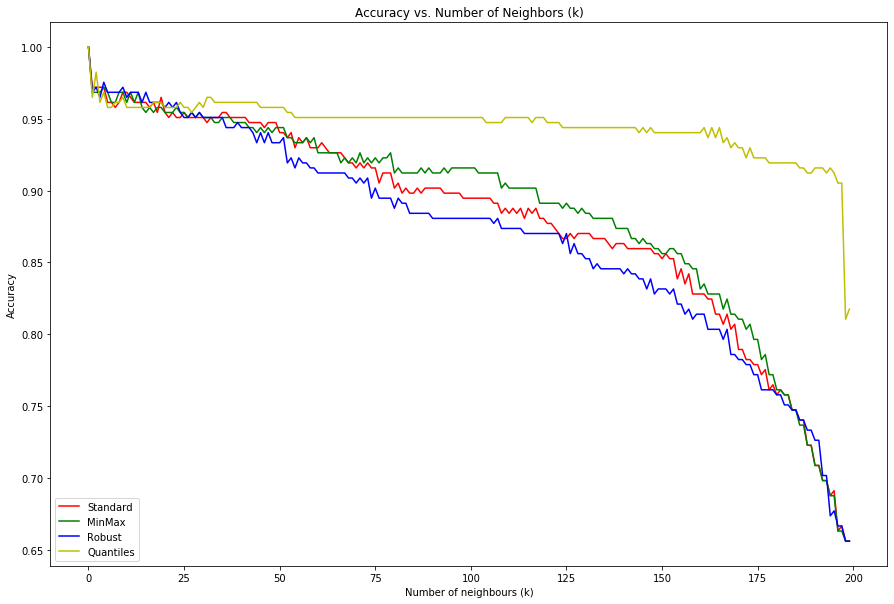

In [5]:
/ initialize the plot
plot:plt[`:subplots][];
fig:plot[@;0];
ax:plot[@;1];

/ obtain results
results[;normalizers;name;maxk]each til count normalizers;

/ customize the plot
fig[`:set_figheight]10;
fig[`:set_figwidth]15;
plt[`:xlabel]"Number of neighbours (k)";
plt[`:ylabel]"Accuracy";
plt[`:title ]"Accuracy vs. Number of Neighbors (k)";
plt[`:legend][`loc pykw"lower left"];
plt[`:show][];

The different scalers perform comparably for the optimal values.  However, the quantiles tranformer proves considerably more robust as k increases. This suggests that, at least for a subset of the features, ordering is more important compared to actual feature values.

---

# MNIST (Handwritten Digits) Database

The [Modified National Institute of Standards and Technology (MNIST) Database](https://keras.io/datasets/), is a large collection of handwritten digits.

MNIST is commonly used for training and testing image processing systems, particularly in the field of machine learning.

### Load data

In the cell below, we load data from the MNIST database imto training and testing sets.

In [5]:
mnist:.p.import[`keras.datasets.mnist][`:load_data;<][]
data:raze(`xtrain`ytrain;`xtest`ytest)!'mnist
data:@[data;`xtrain`xtest;%;255]
data:@[data;`ytrain`ytest;"f"$]

/ inspect data
-1 string[count data`xtrain]," samples of shape ",sv[" x "]string 1_.ml.shape data`xtrain;
-1"";show 5#data`xtrain;-1"";
-1"Distribution of target values is:\n";
show update pcnt:round[;.01]100*num%sum num from select num:count i by target from([]target:data`ytrain);
-1"\nTraining/test split is:\n";
show count each data;

Using TensorFlow backend.


[0;31mimport: No module named 'tensorflow'[0m: [0;31mimport: No module named 'tensorflow'[0m

### One-Hot Encoding

One-hot encoding is a method of encoding categorical variables to be more appropriate for machine learning algorithms.

We assign an integer index to each distinct category and represent each value with a vector of `0`s and `1`s. The vector has length equal to the number of distinct categories, with a `0` in every position except the relevant category index, given value `1`.

Consider categorical data drawn uniformly from 3 classes:

In [7]:
show example:10?`AAA`BBB`CCC

`AAA`CCC`AAA`BBB`CCC`AAA`BBB`CCC`CCC`CCC


We use one-hot encoding to replace each point with a vector (of length 3) with a `1` indicating the original category.

In [8]:
.ml.i.onehot1 example

AAA| 1 0 1 0 0 1 0 0 0 0
BBB| 0 0 0 1 0 0 1 0 0 0
CCC| 0 1 0 0 1 0 0 1 1 1


The advantage of using this method over converting target to numberical values, e.g. 0 1 2, is that the numerical values will be interpreted by the model as having an order.

In some situations this may be fine, for example if we have:
```
Small (0)
Medium (1)
Large (2)
```

However, it will cause problems when there is no intrinsic ordering, e.g.:
```
London (0)
Paris (1)
New York (2)
```

Given this encoding, a machine learning algorithm may assume an ordering that is not there, e.g. it could infer that Paris is, in some way, between London and New York.

We will investigate the impact of using one-hot encoding vs. basic enumeration using a neural network applied to the MNIST dataset.

### One-hot encode targets

We now apply onehot encoding to the target vectors. We also prepare the feature data for the neural network model by reshaping it to flattened arrays.

In [9]:
/ one-hot encode targets and convert to numpy arrays
data:@[data;`otrain`otest;:;{flip value .ml.i.onehot1 x}each data`ytrain`ytest]
data:@[data;`ytrain`ytest`otrain`otest;npa]

/ reshape images
data:@[data;`xtrain`xtest;{npa[(raze/)x][`:reshape]count[x],28 28 1}]

### Build and train models

Below separate neural network models are define to train on both:
- Continuous labels.
- One-hot encoded labels.

We begin by importing the relevant models, optimizers and layers.

In [10]:
/ Keras building blocks of model
sequential:.p.import[`keras.models]`:Sequential
adadelta:  .p.import[`keras.optimizers]`:Adadelta
layers:    .p.import[`keras.layers]
conv2d:    layers`:Conv2D
maxpool2d: layers`:MaxPooling2D
dense:     layers`:Dense
dropout:   layers`:Dropout
flatten:   layers`:Flatten

In [11]:
/ function to create a continuous-valued model
continuousmodel:{
  model:sequential[];
  model[`:add]conv2d[32;`kernel_size pykw 3 3;`activation pykw`relu;`input_shape pykw 28 28 1];
  model[`:add]conv2d[64;`kernel_size pykw 3 3;`activation pykw`relu];
  model[`:add]maxpool2d[`pool_size pykw 2 2];
  model[`:add]flatten[];
  model[`:add]dense[128;`activation pykw`relu];
  model[`:add]dense[1;`activation pykw`relu];
  model[`:compile][`loss pykw`mean_squared_error;`optimizer pykw adadelta[];`metrics pykw .p.list enlist`accuracy];
  model}
continuousmodel[][`:summary][];

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 1,198,721
Trainable params: 1,198,721
Non-trainable params: 0
_________________________________________________________________


In [12]:
/ function to create a one-hot encoded model
onehotmodel:{
  model:sequential[];
  model[`:add][conv2d[32;`kernel_size pykw 3 3;`activation pykw`relu;`input_shape pykw 28 28 1]];
  model[`:add][conv2d[64;`kernel_size pykw 3 3;`activation pykw`relu]];
  model[`:add]maxpool2d `pool_size pykw 2 2;
  model[`:add]dropout 0.25;
  model[`:add]flatten[];
  model[`:add]dense[128;`activation pykw`relu];
  model[`:add]dropout .5;
  model[`:add]dense[10;`activation pykw`softmax];
  model[`:compile][`loss pykw `categorical_crossentropy;`optimizer pykw adadelta[];`metrics pykw .p.list enlist`accuracy];
  model}
onehotmodel[][`:summary][];

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
__________

In [13]:
/ inputs
epochs:20
batchsz:128

In [14]:
/ fit continuous model
cmodel:continuousmodel[];
start:.z.T
cresults:cmodel[`:fit][data`xtrain;data`ytrain;`batch_size pykw batchsz;`verbose pykw 3;
 `epochs pykw epochs;`validation_data pykw(data[`xtest]`.;data[`ytest]`.)]
-1"Training continuous model for ",string[epochs]," epochs took ",string .z.T-start;

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Training continuous model for 20 epochs took 00:19:46.821


In [15]:
/ fit one-hot model
omodel:onehotmodel[];
start:.z.T
oresults:omodel[`:fit][data`xtrain;data`otrain;`batch_size pykw batchsz;`verbose pykw 3;
 `epochs pykw epochs;`validation_data pykw(data[`xtest]`.;data[`otest]`.)]
-1"Training one-hot model for ",string[epochs]," epochs took ",string .z.T-start;

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Training one-hot model for 20 epochs took 00:19:53.006


### Results

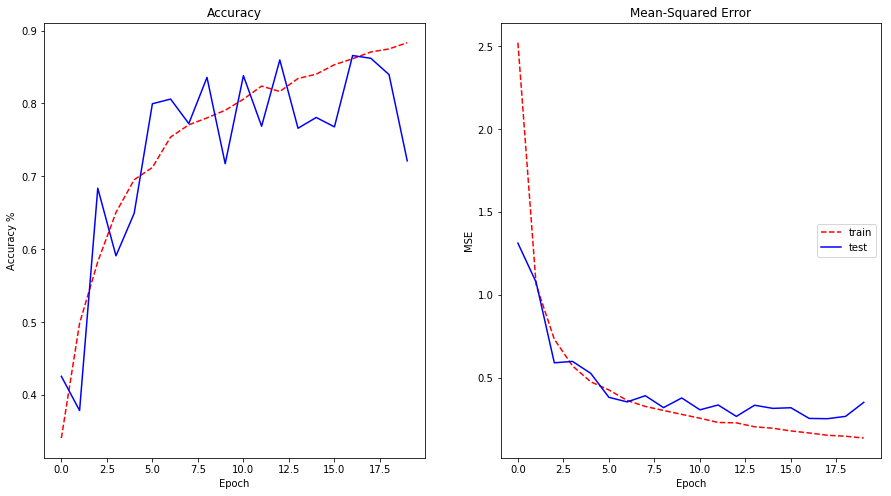

In [16]:
/ performance of continuous model
history:cresults[`:history]`
plotAccMSE . history`acc`val_acc`loss`val_loss;

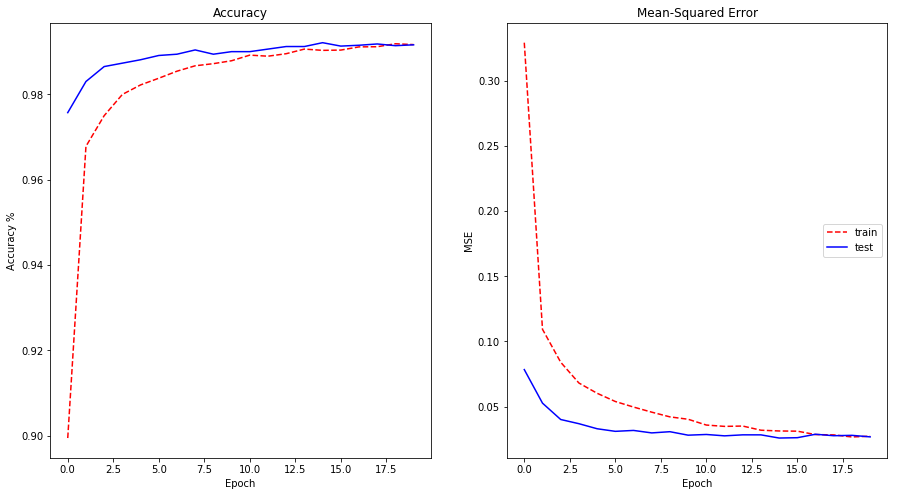

In [17]:
/ performance of one-hot model
history:oresults[`:history]`
plotAccMSE . history`acc`val_acc`loss`val_loss;

### Conclusions

The continuous-valued model achieves 86% accuracy after 20 epochs, with performance fairly erratic across successive epochs. 

In comparison, the model with one-hot encoding provides smoother prediction accuracy. It also achieves an accuracy over 90% accuracy after just 1 epoch, increasing to 99% after just a few epochs.

A technical explanation, is that one-hot encoding allows the backpropagation algorithm to provide separate training signals for each image class.

Training with one-hot labels therefore seems considerably faster and, ultimately, more successful.

---